# Simple example of (over)fitting a potential using BS04 descriptors 

MONACOSTE Summer School 2022

Tom Swinburne 2022 https://tomswinburne.github.io\\

In [1]:
import pickle,time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge

In [2]:
def line(v):
    l = np.linspace(v.min(),v.max(),11)
    return l,l

def jmax_select_vector(twojmax=8,quad=False):
    sel = np.zeros((56),bool)
    assert twojmax<=8 and twojmax%2==0
    sel[0] = True
    c = 0
    for j1 in range(0,twojmax+1):
        for j2 in range(0,j1+1):
            for j in range(j1-j2,min(twojmax,j1+j2)+1,2):
                if (j>=j1): 
                    sel[c+1] = True
                    c+=1
    if quad:
        quad_sel = np.outer(sel[1:],sel[1:])[np.triu_indices(sel.size-1)]
        sel = np.append(sel.copy(),quad_sel)                                     
    return sel

def load_data(pkl_file,num_desc=56,quad=True):
    if quad:
        num_desc += ((num_desc-1)*num_desc)//2
    data = pickle.load(open(pkl_file,"rb"))
    for f in ['A','a','t']:
        data[f] = np.array(data[f])
    data['A'] = data['A'].reshape((data['a'].size,-1))
    data['A'] = data['A'][:,:num_desc]
    data['is_energy'] = np.array(data['is_energy'],bool).flatten()
    data['is_minima'] = np.array(data['is_minima'],bool).flatten()
    return data.copy()    

def plot_results(axs,d,models,sel,fit_mask):
    A = d['A'][:,sel]
    t = d['t']
    a = d['a']
    a_energies = a[d['is_energy']]
    A_energies = A[d['is_energy']]
    t_energies = t[d['is_energy']]
    
    A_forces = A[~d['is_energy']]
    t_forces = t[~d['is_energy']]
    
    
    A_fit = A[fit_mask]
    t_fit = t[fit_mask]
    w_fit = np.where(d['is_energy'],1.0,0.01)[fit_mask]
    W_fit = np.diag(w_fit)
    
    e_fit_mask = d['is_energy'] * fit_mask
    f_fit_mask = ~d['is_energy'] * fit_mask
    
    for model in models:
        models[model].fit(A_fit,t_fit,w_fit)
    
        
    plt_data = lambda ax,x,y,l,u="eV",c=0: ax.plot(x,y,f'C{c}.',label=l+" %2.2g m" % (1000.0*np.abs(x-y).mean())+u)
    is_minima = d['is_energy']
    
    axs[0].plot(a[is_minima],t[is_minima],'ko',label='Reference')
    for im,model in enumerate(models):
        axs[0].plot(a[is_minima],models[model].predict(A[is_minima]),f'C{im}.',label=model)
    
    axs[0].legend(fontsize=8)
    dE = t[is_minima].max()-t[is_minima].min()
    axs[0].set_ylim(t[is_minima].min() - dE*0.5 ,t[is_minima].max() + dE*0.5)
    
    axs=axs[1:]
    axs[0].plot(*line(t_energies),'k--',label='Reference')
    if e_fit_mask.sum():
        for im,model in enumerate(models):
            plt_data(axs[0],t[e_fit_mask],models[model].predict(A[e_fit_mask]),l=model,c=im)
        axs[0].legend(fontsize=8)
    axs[0].set_xlim(t_energies.min(),t_energies.max())
    axs[0].set_ylim(t_energies.min(),t_energies.max())
    
    for im,model in enumerate(models):
        plt_data(axs[1],t_energies,models[model].predict(A_energies),l=model,c=im)
    axs[1].legend(fontsize=8)
    axs[1].set_xlim(t_energies.min(),t_energies.max())
    axs[1].set_ylim(t_energies.min(),t_energies.max())

    
    axs[2].plot(*line(t_forces),'k--',label='Reference')
    if f_fit_mask.sum():
        for im,model in enumerate(models):
            plt_data(axs[2],t[f_fit_mask],models[model].predict(A[f_fit_mask]),l=model,u="eV/A",c=im)

        axs[2].legend(fontsize=8)
    axs[2].set_xlim(t_forces.min(),t_forces.max())
    axs[2].set_ylim(t_forces.min(),t_forces.max())
    
    axs[3].plot(*line(t_forces),'k--',label='Reference')
    for im,model in enumerate(models):
        plt_data(axs[3],t_forces,models[model].predict(A_forces),l=model,u="eV/A",c=im)
    axs[3].legend(fontsize=8)
    axs[3].set_xlim(t_forces.min(),t_forces.max())
    axs[3].set_ylim(t_forces.min(),t_forces.max())
    
    

Define Models We Will Use

In [3]:
class LinearSolve:
    def __init__(self):
        """
            Simple Linear Solve
        """
        self.Theta = None
    def fit(self,A,t,w):
        self.Theta = np.linalg.solve(A.T@np.diag(w)@A,A.T@np.diag(w)@t)
    def predict(self,A):
        return A@self.Theta

class RidgeSolve:
    def __init__(self):
        """
            Wrapper around sklearn's Bayesian Ridge
        """
        self.model = BayesianRidge(fit_intercept=False)
        
    def fit(self,A,t,w):
        self.model.fit(A,t,w)
        
    def predict(self,A):
        return self.model.predict(A)

In [4]:
data = load_data("Training_Data_Bulk_Small.pkl",quad=False)
data_quad = load_data("Training_Data_Bulk_Small.pkl",quad=True)

In [7]:
test_train_split = 0.1
fit_masks = {'Minima Only' : data['is_minima'], 
             'Energy Only' : data['is_energy'], 
             '10% Energies & Forces' : np.random.uniform(size=data['is_energy'].size)<test_train_split}

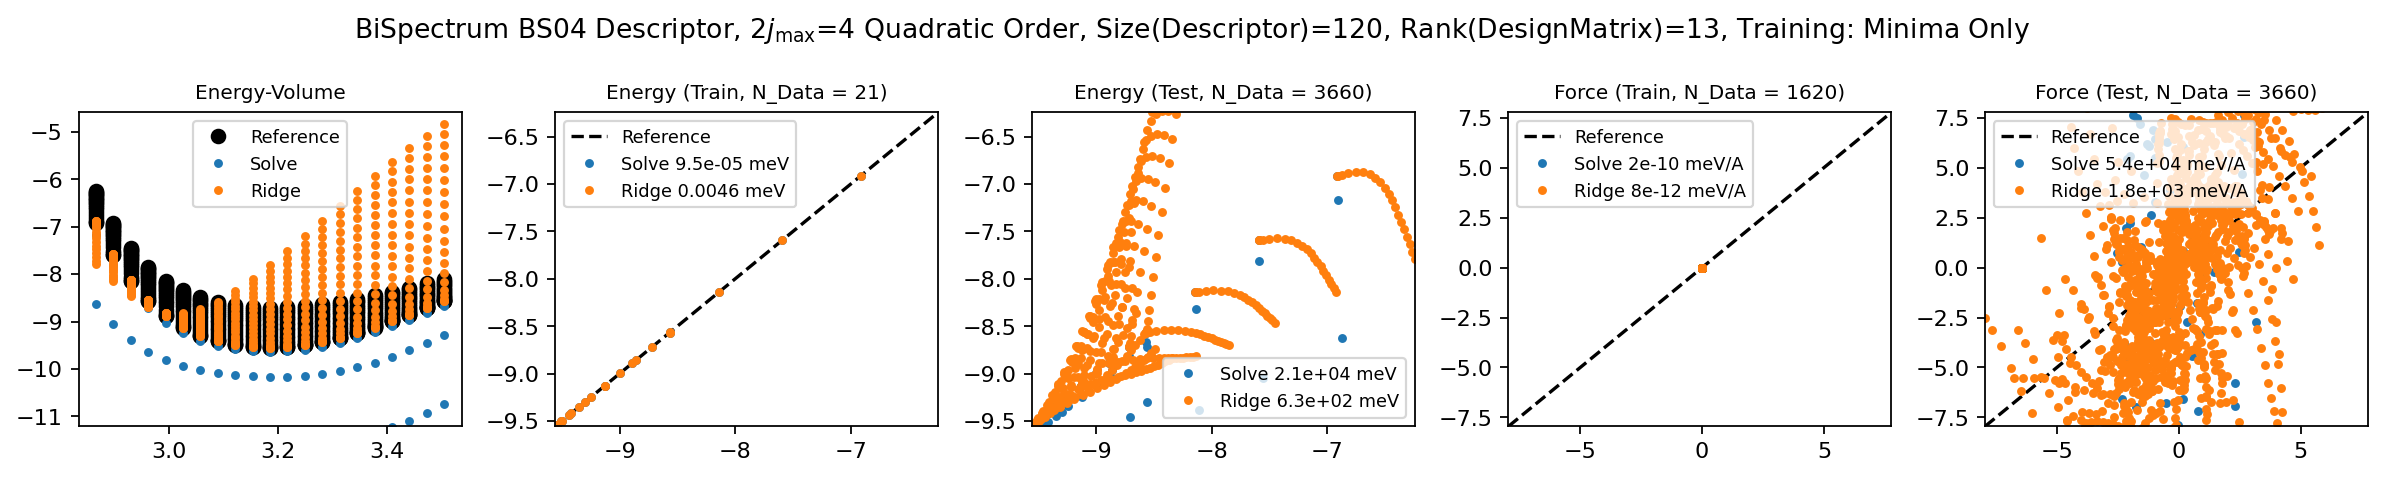

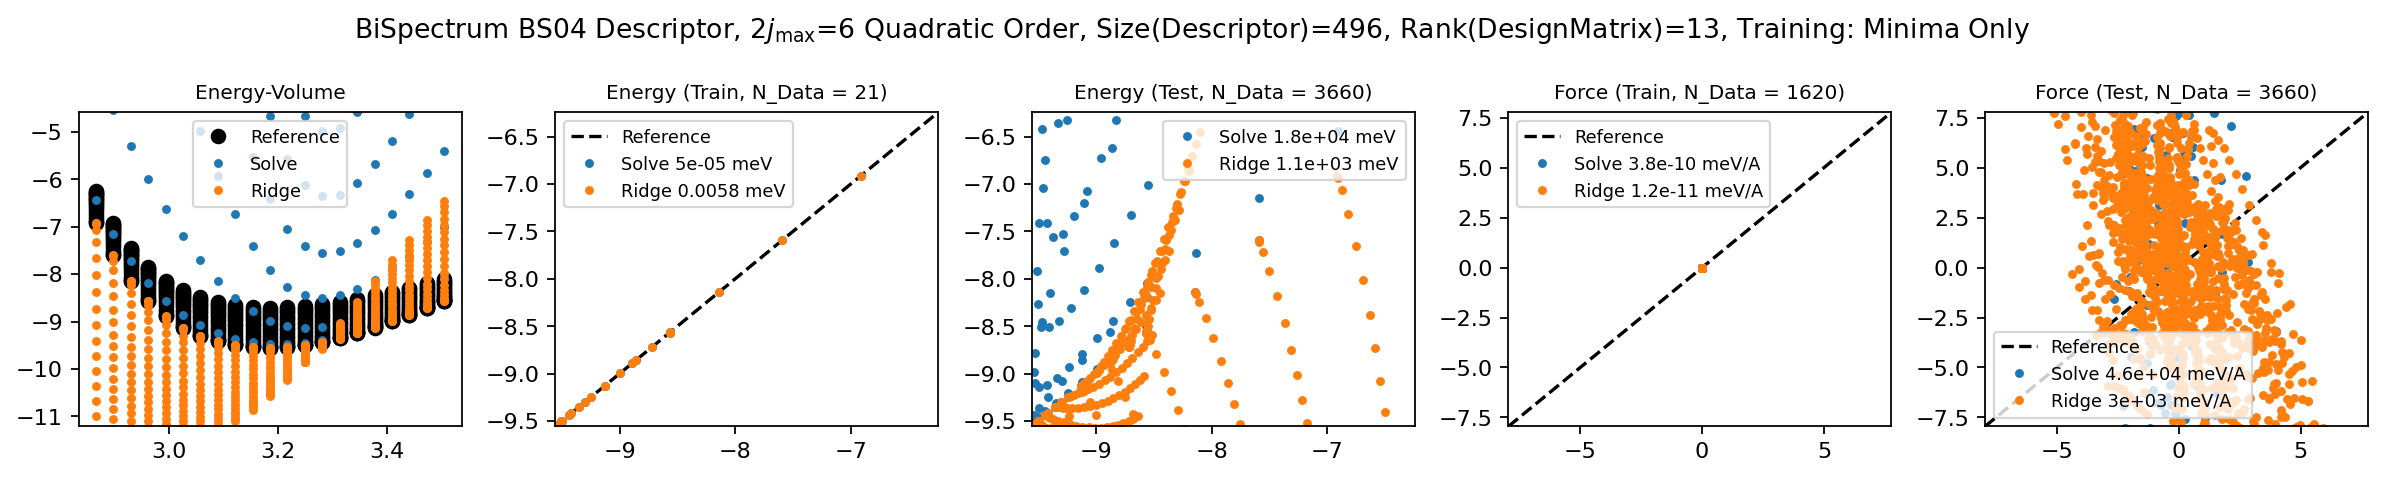

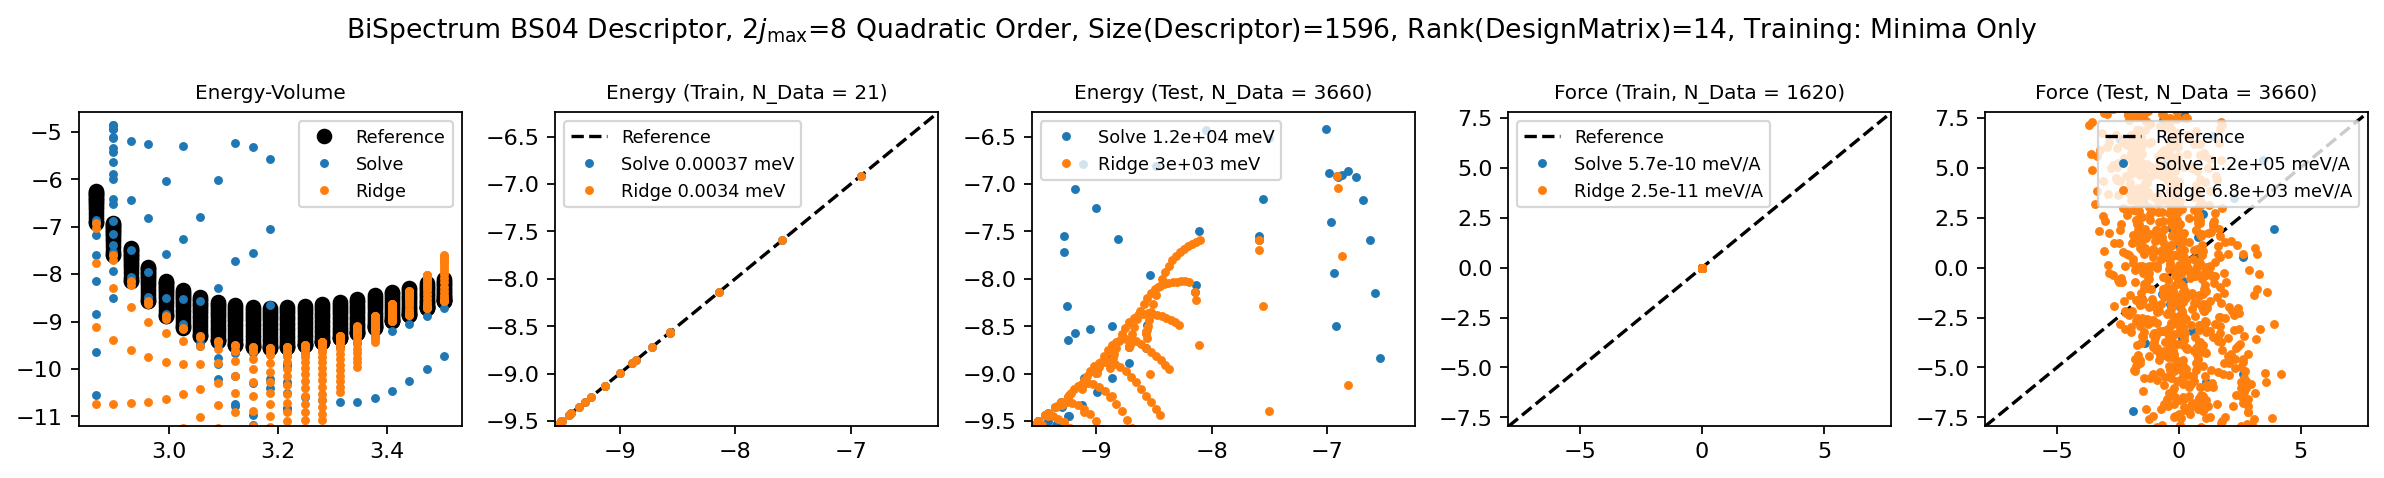



NEXT TRAINING SET




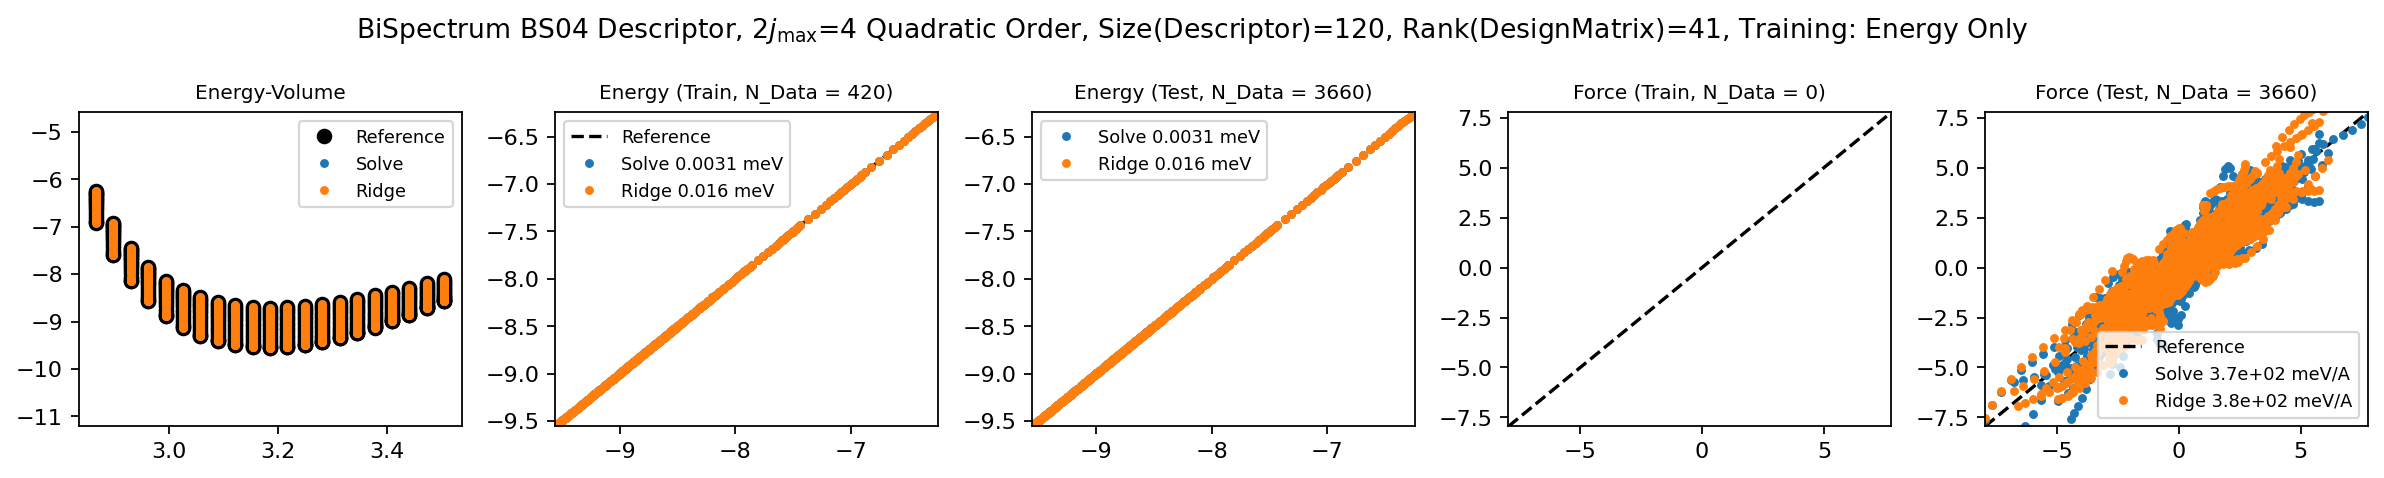

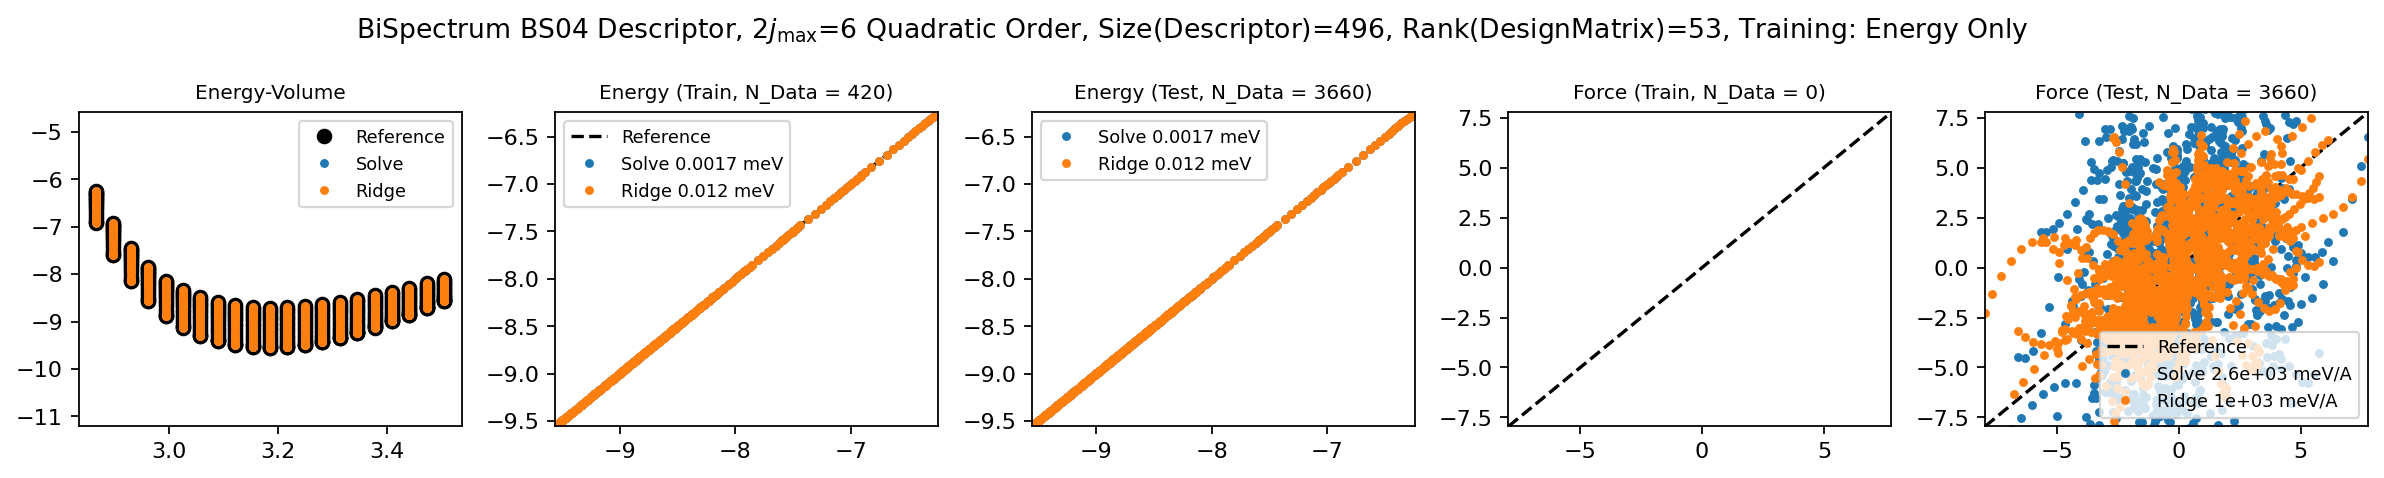

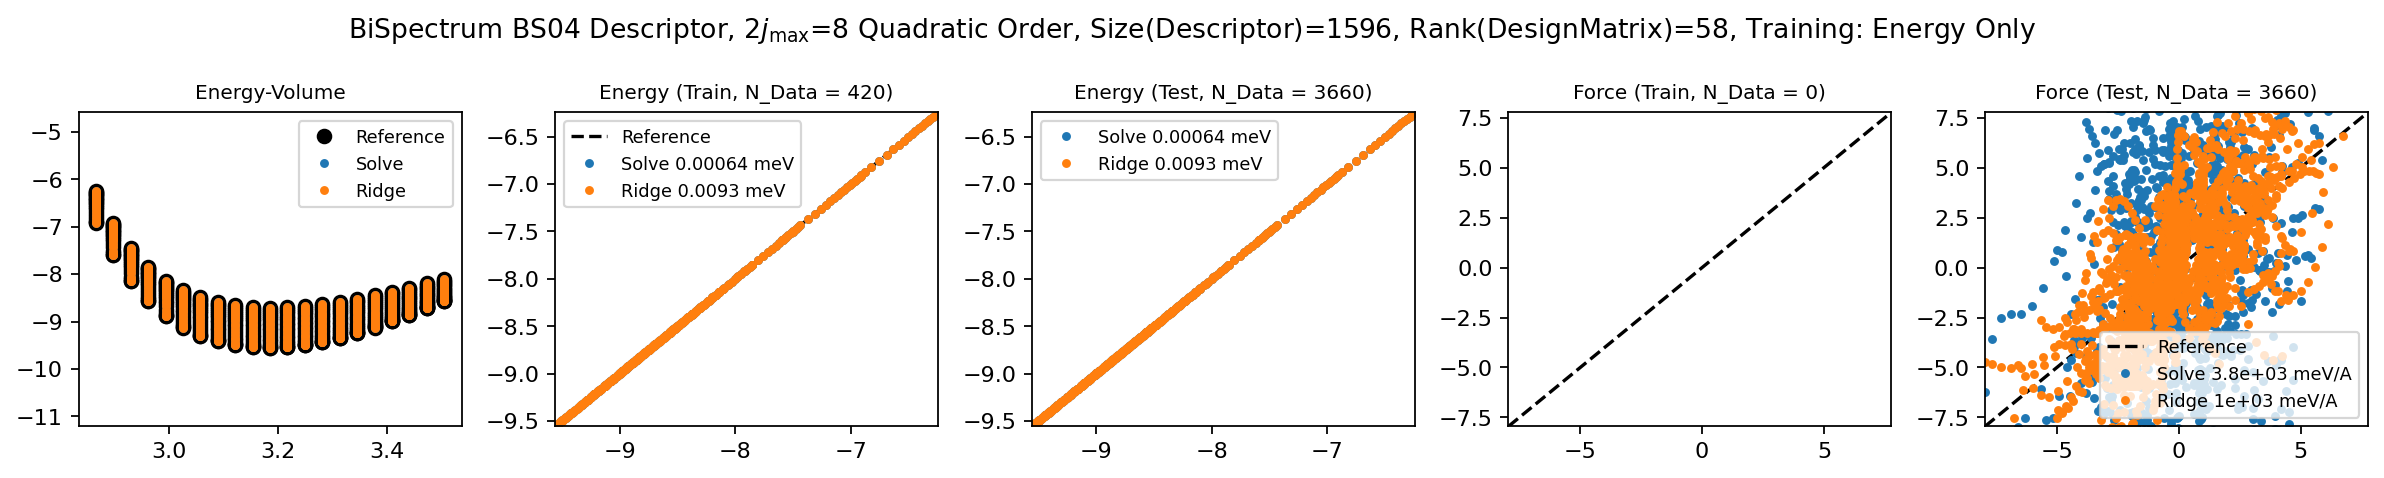



NEXT TRAINING SET




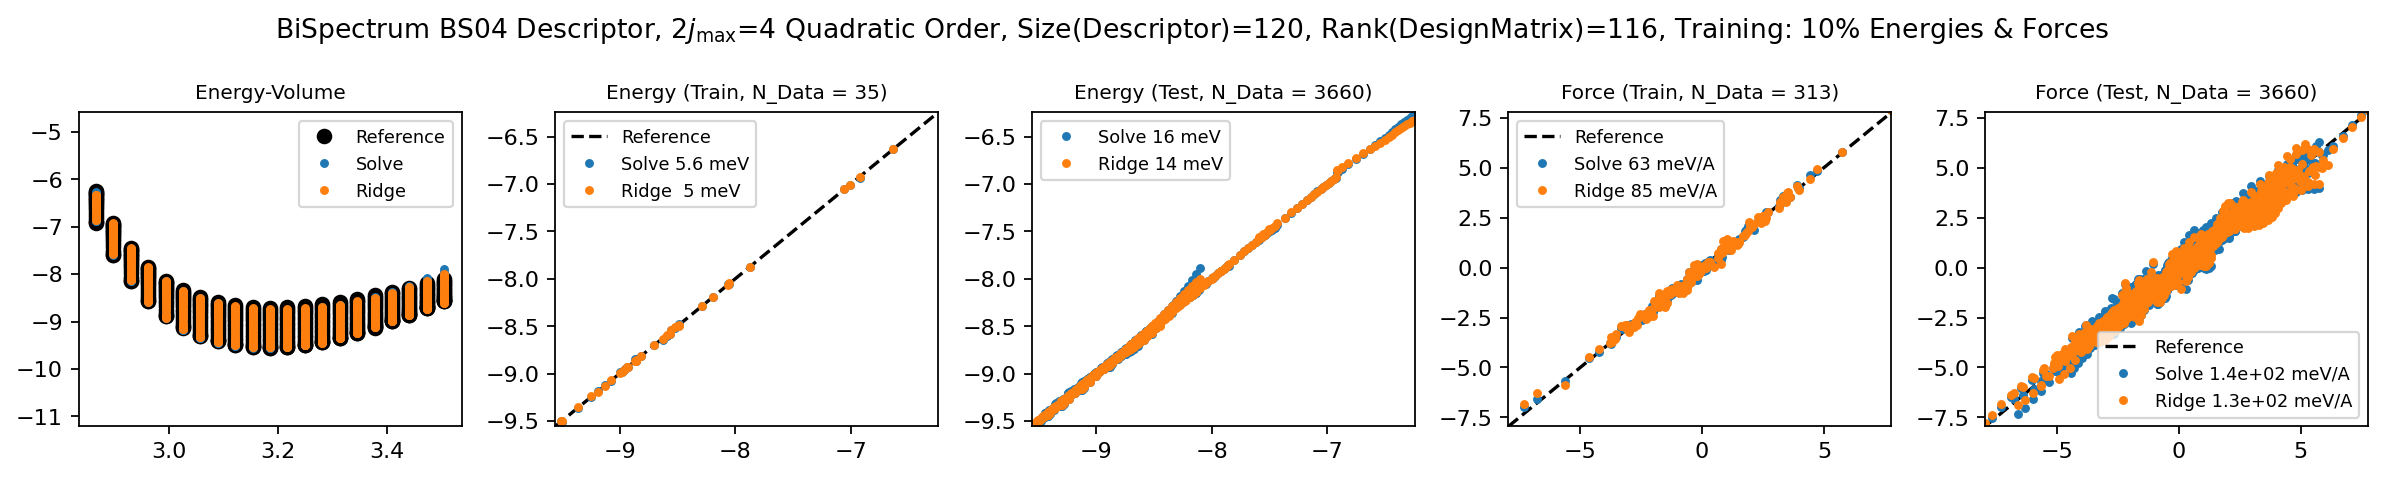

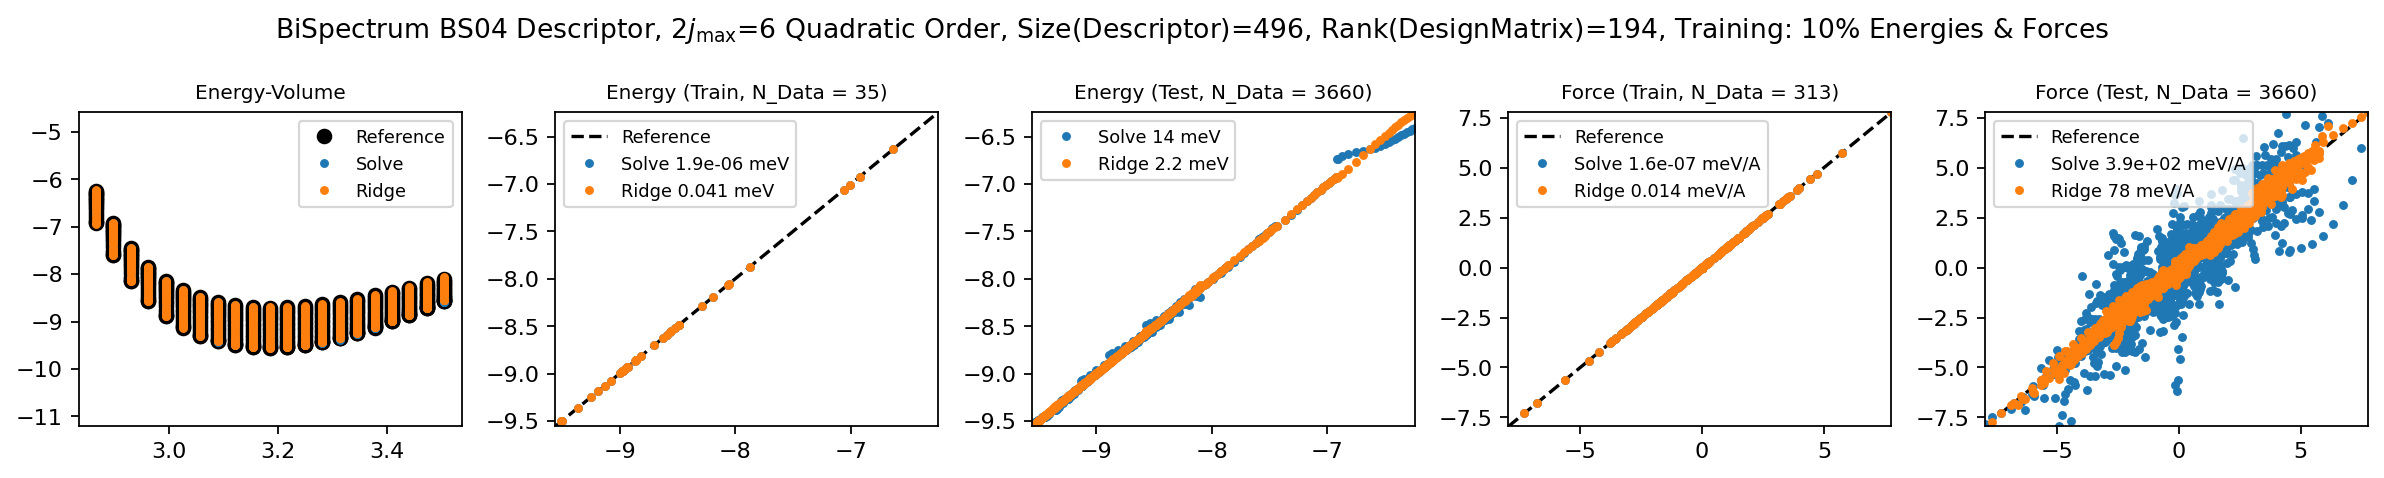

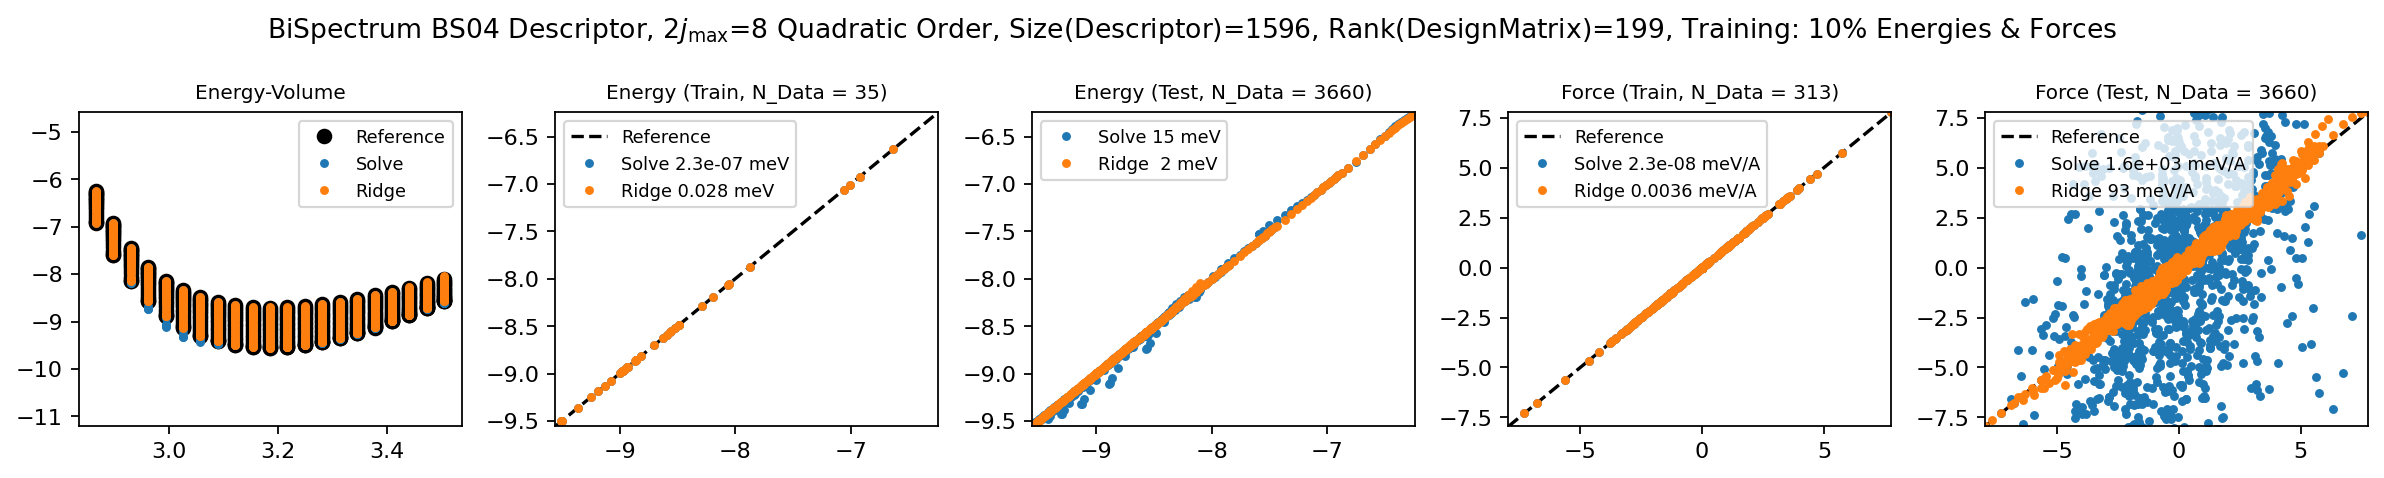



NEXT TRAINING SET




In [9]:

for fit in fit_masks:

    models = {"Solve":LinearSolve(),"Ridge":RidgeSolve()}
    for i,twojmax_quad in enumerate(zip([4,6,8],[True,True,True])):
        
        fit_mask = fit_masks[fit]
        fig,axs = plt.subplots(1,5,figsize=(15,3),sharex='col',sharey='col',dpi=160)
        axs[0].set_title("Energy-Volume",fontsize=9)
        axs[1].set_title("Energy (Train, N_Data = %d)" % ((data['is_energy']*fit_mask).sum()),fontsize=9)
        axs[2].set_title("Energy (Test, N_Data = %d)" % (fit_mask.size),fontsize=9)
        axs[3].set_title("Force (Train, N_Data = %d)" % (((~data['is_energy'])*fit_mask).sum()),fontsize=9)
        axs[4].set_title("Force (Test, N_Data = %d)" % (fit_mask.size),fontsize=9)

        sel = jmax_select_vector(twojmax_quad[0],quad=twojmax_quad[1])
        d = [data,data_quad][twojmax_quad[1]]
        rank = lambda _A : np.linalg.matrix_rank(_A.T@_A)
        plot_results(axs,d,models,sel,fit_mask)
        title = r"BiSpectrum BS04 Descriptor, $2j_{\rm max}$=%d " % twojmax_quad[0]
        title += ["Linear","Quadratic"][twojmax_quad[1]]+" Order, "
        title += f"Size(Descriptor)={sel.sum()}, Rank(DesignMatrix)={rank(d['A'][fit_mask,:][:,sel])}"
        title += ", Training: "+fit
        fig.suptitle(title)
        plt.tight_layout()
        plt.show()
    print("\n\nNEXT TRAINING SET\n\n")